In [49]:
%pylab inline
import numpy as np
from scipy import integrate
from scipy.special import gamma
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import qutip.ipynbtools
import scipy.stats
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['Annotation', 'f', 'Figure', 'gamma']
`%matplotlib` prevents importing * from pylab and numpy



In [50]:
gcoll = 2*pi*8.31 #HWHM
kappa = 4.4*pi*2 #HWHM
q = 1.389
delta = 0*2*pi
deltac = 0*2*pi
gperp = 2*pi*0.06 #HWHM
gpar = 2*pi*0.00001 #HWHM
gammaq = 2*pi*9.4 #FWHM
nspins = 10000#5000#20
g0 = gcoll/sqrt(nspins)

In [51]:
def odeintz(func, z0, t, **kwargs):
    """An odeint-like function for complex valued differential equations."""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = integrate.odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z

In [52]:
def tsallis(f, q, width):
    delta = (width)/2*sqrt(2*q-2)/sqrt(2**q-2)/sqrt(2)
    norm = sqrt(q-1)*gamma(1/(q-1))/(sqrt(2*pi)*delta*gamma((3-q)/(2*(q-1))))
    val = (1+(q-1)*f**2/delta**2/2)**(1/(1-q))
    return norm*val

In [53]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx, array[idx]

def cauchy(x, pos, fwhm, ampl):
    return 1/((x-pos)**2+0.25*fwhm**2)*0.25*fwhm**2*ampl

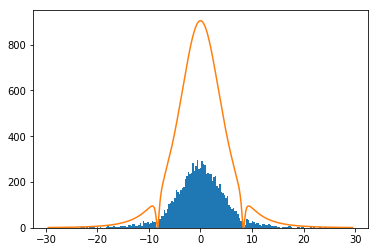

In [54]:
holes = True #set to true if you want to include holes in your simulation
inhomo = True #do you want inhomogneous broadening

f = np.linspace(-gammaq/2, gammaq/2, 10000 )
pdf = tsallis(f, q, gammaq/2/pi)


if holes:
    frequency_exclude = gcoll/2/pi
    exclude_width = 0.8 #FWHM

    indf, freq = find_nearest(f, frequency_exclude)
    scale = pdf[indf]

    toex = cauchy(f, frequency_exclude, exclude_width, -scale)+cauchy(f, -frequency_exclude, exclude_width, -scale)
    pdf = pdf+toex

pdf = clip(pdf, 0, max(pdf) )   
    
spdf = sum(pdf)
pdf = pdf/spdf    
    
spins = numpy.random.choice(f, p=pdf, size=nspins) #draw samples according to distribution
if inhomo:
    figure()
    hist(spins, 200);
    plot(f, pdf*nspins*spdf)
else:
    #print(spins)
    spins = zeros(shape(spins))

In [55]:
def func(a, eta, deltdrive):
    spins2 = 2*pi*(spins)+deltdrive
    sn = gperp-1j*spins2 
    sd = gpar*gperp**2+4*np.abs(a)**2*g0**2*gperp+gpar*spins2**2
    s = sn/sd
    
    ret = 1j*a*deltdrive + eta + a*kappa + a*g0**2*gpar*np.sum(s)
    return ret.real, ret.imag

def a_steady(eta, deltadrive, init):

    def equations(x):
        ar, ai = x
        return func(ar+1j*ai, eta, deltadrive)
    ar, ai = fsolve(equations, init)

    return ar, ai

array([-8.4192096])

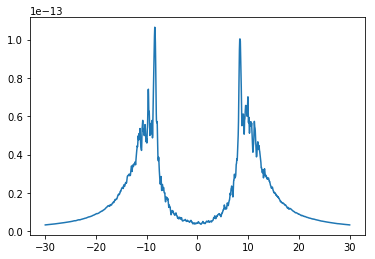

In [56]:
initsteady = (0.,0.1)
fstart = 30
deltaarr = linspace(-fstart*2*pi,fstart*2*pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2

fig = figure()
plot(deltaarr/2/pi, losasteady)
deltaarr[find(losasteady == max(losasteady))]/2/pi

In [35]:
#this is as optimized as possible using numpy slicing so calling this function SHOULD be very fast
ret = np.zeros(nspins*2+1, dtype=complex)
def mbes(Y, t, eta):
    ret[0] = -kappa*Y[0]-1j*deltac*Y[0]+g0*np.sum(Y[1::2])+eta
    ret[1::2] = -(gperp+1j*spins*2*pi)*Y[1::2]+g0*Y[2::2]*Y[0]
    ret[2::2] = -gpar*(1+Y[2::2])-2*g0*(Y[1::2]*np.conj(Y[0])+np.conj(Y[1::2])*Y[0])
    return ret

#%%timeit gives
#10000 loops, best of 3: 45 µs per loop
#for 800 spins it becomes ~70µs. This is probably not the bottleneck

In [36]:


def do_calculation(drive, tlistpump, tlistafter, init):

    #this should be very fast as well because scipy uses fortran 
    asolpump = odeintz(mbes, init, tlistpump, args=(drive,))
    init2 = asolpump[-1,:]
    asoldecay = odeintz(mbes, init2, tlistafter, args=(0,))

    return asolpump, asoldecay
    #solution is that the first entry is the cavity, and then the first spin (sigma-, sigmaz) then the second etc...

In [41]:
pumptime = 400e-3
endtime = 1500e-3
drive = 0.1

numsteps = 1000

tp = linspace(0,pumptime,numsteps)
tdec = linspace(pumptime, endtime, numsteps)

#starting with all spins down
init = np.ones(nspins*2+1)*(-1)
init[0] = 0
init[1::2] = 0

asolpump, asoldecay = do_calculation(drive, tp, tdec, init)

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning:

Casting complex values to real discards the imaginary part



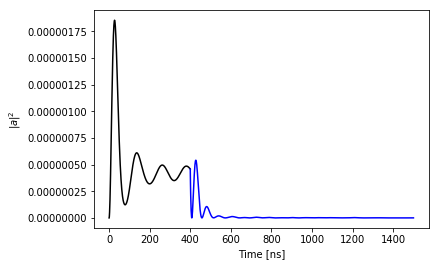

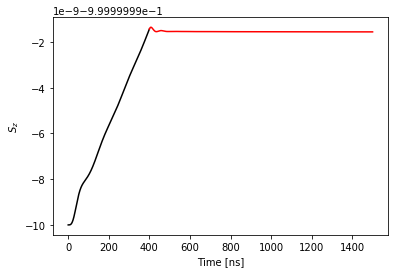

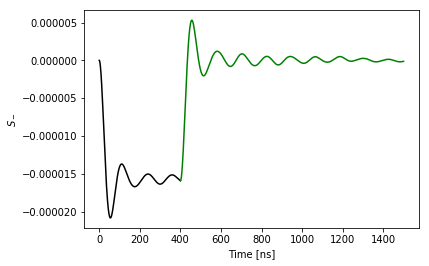

In [42]:
fig1 = figure()
plot(tp*1000, abs(asolpump[:,0])**2, 'k-')
plot(tdec*1000, abs(asoldecay[:,0])**2, 'b-')
xlabel('Time [ns]')
ylabel('$|a|^2$')
#py.iplot_mpl(fig1)
fig2 = figure()
plot(tp*1000, np.sum(asolpump[:, 2::2], axis=1)/nspins, 'k-')
plot(tdec*1000, np.sum(asoldecay[:, 2::2], axis=1)/nspins, 'r-')
xlabel('Time [ns]')
ylabel('$S_z$')
#py.iplot_mpl(fig2)
fig3 = figure()
plot(tp*1000, np.sum(asolpump[:, 1::2], axis=1)/nspins, 'k-')
plot(tdec*1000, np.sum(asoldecay[:, 1::2], axis=1)/nspins, 'g-')
xlabel('Time [ns]')
ylabel('$S_-$')
#py.iplot_mpl(fig3)

In [47]:
#tlistpump, asolpump, tlistafter, asoldecay = do_calculation(pumptime, endtime, drive)
drive = 3000
pumptime = 100e-3
numsteps = 1000


tall = linspace(0, endtime, numsteps)


drivelist = linspace(0, drive, 100)
pumptimelist = linspace(40e-3, pumptime, 60)


pulselength = True #change if you want to simulate different pulselengths / drive powers

p = qutip.ipynbtools.HTMLProgressBar()
if pulselength:
    p.start(iterations=len(pumptimelist))
    p.N = len(pumptimelist)
    los = zeros((len(pumptimelist), numsteps, 3), dtype=complex128)
    for i, pl in enumerate(pumptimelist):
        tp = tall[:int(ceil(pl/endtime*numsteps))]
        tdec = tall[int(ceil(pl/endtime*numsteps)):]
        losp, losdec = do_calculation(drive, tp, tdec, init)
        # i can for now only keep the collective operators otherwise I don't have enough RAM
        los[i,:len(tp), 0] = losp[:,0]
        los[i,len(tp):, 0] = losdec[:,0]
        los[i,:len(tp),1] = mean(losp[:, 1::2], axis=1)
        los[i,len(tp):,1] = mean(losdec[:, 1::2], axis=1)
        los[i,:len(tp),2] = mean(losp[:, 2::2], axis=1)
        los[i,len(tp):,2] = mean(losdec[:, 2::2], axis=1)
        p.update(i)
    p.finished()

else:
    p.start(iterations=len(drivelist))
    p.N = len(drivelist)
    los = zeros((len(drivelist), numsteps, 3), dtype=complex128)
    for i, dri in enumerate(drivelist):
        tp = tall[:int(ceil(pumptime/endtime*numsteps))]
        tdec = tall[int(ceil(pumptime/endtime*numsteps)):]
        losp, losdec = do_calculation(dri, tp, tdec, init)
        # i can for now only keep the collective operators otherwise I don't have enough RAM
        los[i,:len(tp), 0] = losp[:,0]
        los[i,len(tp):, 0] = losdec[:,0]
        los[i,:len(tp),1] = mean(losp[:, 1::2], axis=1)
        los[i,len(tp):,1] = mean(losdec[:, 1::2], axis=1)
        los[i,:len(tp),2] = mean(losp[:, 2::2], axis=1)
        los[i,len(tp):,2] = mean(losdec[:, 2::2], axis=1)
        p.update(i)
    p.finished()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:531: ComplexWarning:

Casting complex values to real discards the imaginary part



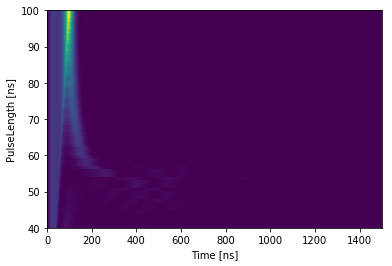

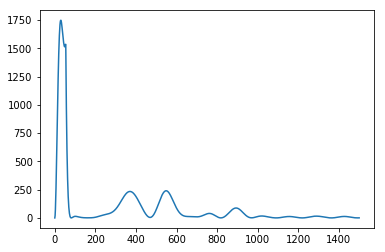

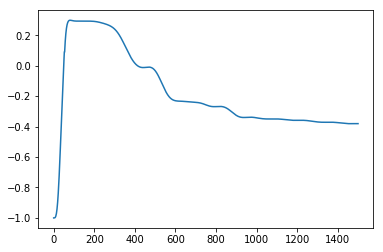

In [48]:
cavampl = abs(los[:, :, 0])**2

if pulselength:
    pcolor(tall*1000, pumptimelist*1000, cavampl)
    ylabel('PulseLength [ns]')
else:
    pcolor(tall*1000, drivelist, cavampl)
    ylabel('Drive Amplitude [a.u.]')
xlabel('Time [ns]')
#clim([0,200])
figure()
plot(tall*1000, cavampl[13,:])
figure()
plot(tall*1000, los[13, : ,2])